In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_item, show_grasp
from dataset import ToyGraspDataset
import torch

np.random.seed(10)
torch.manual_seed(10)

Outline
1. Make datasets
2. Train Network
3. Save results

In [2]:
item = load_item('fork')

In [3]:
dataset = ToyGraspDataset(root='data', size=1200)

In [4]:
pos_ind = np.argwhere(dataset.data[:,2] == 1)
neg_ind = np.argwhere(dataset.data[:,2] == 0)

pos_ind = np.random.choice(pos_ind.squeeze(), 5)
neg_ind = np.random.choice(neg_ind.squeeze(), 5)

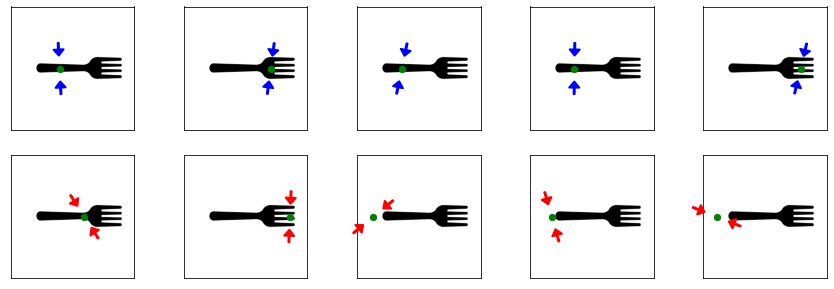

In [5]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15,5))

for i in range(5):
    ax[0][i].imshow(item, cmap='Greys')
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    sample = dataset.data[pos_ind[i]]
    show_grasp(ax[0][i], sample[0], sample[1], sample[2] )
    ax[1][i].imshow(item, cmap='Greys')
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    sample = dataset.data[neg_ind[i]]
    show_grasp(ax[1][i], sample[0], sample[1], sample[2] )

In [6]:
# show the data
data = dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks
handle_masks = data[:,3] == 1
pos_combined_masks = handle_masks & pos_masks
neg_combined_masks = handle_masks & neg_masks

In [7]:
data[:,1]

array([6.158016  , 3.0941987 , 2.027204  , ..., 1.9849807 , 0.23419897,
       4.6233106 ], dtype=float32)

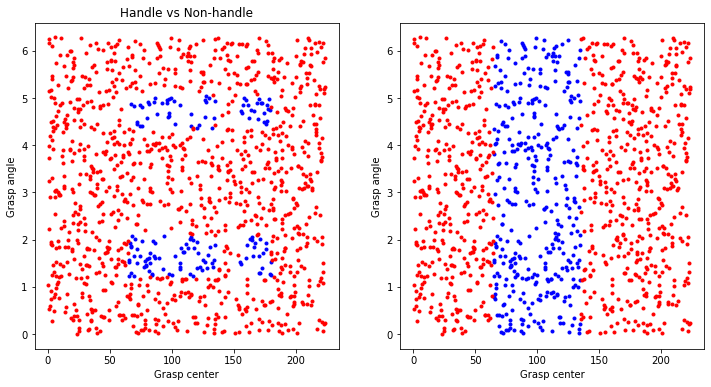

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax[0].scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax[0].set_title('Pos vs Neg')
ax[0].set_xlabel('Grasp center')
ax[0].set_ylabel('Grasp angle')

ax[1].scatter(data[handle_masks][:,0], data[handle_masks][:,1], marker='.', alpha=1.0, color='b')
ax[1].scatter(data[~handle_masks][:,0], data[~handle_masks][:,1], marker='.', alpha=1.0, color='r')
ax[0].set_title('Handle vs Non-handle')
ax[1].set_xlabel('Grasp center')
ax[1].set_ylabel('Grasp angle')
plt.show()

### Real+ vs Sim+

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN, train_network, save_model_info, load_model_info

from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.manual_seed(42)


sim2real!!!


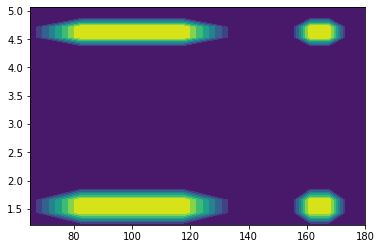

In [51]:
# USING 2D FORK DATA ===============================

n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=1000, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)



# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
train_y = torch.Tensor(train_dataset.data[:,2]).long().mul(2).sub(1)
x_t = train_x.clone()
# Normalize inputs
x_t[:,0] /= 244
x_t[:,1] /= (3.14*2)

y = train_dataset.data[:,2].reshape(-1,1)

test_x = torch.Tensor(test_dataset.data[:,:2])
test_x_mat = torch.reshape(test_x[:,0], (n, n))
test_y_mat = torch.reshape(test_x[:,1], (n, n))

test_y = torch.Tensor(test_dataset.data[:,2]).long().mul(2).sub(1)
test_labels = torch.reshape(test_y, (n, n))

plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

pos_masks = train_y == 1
neg_masks = ~pos_masks

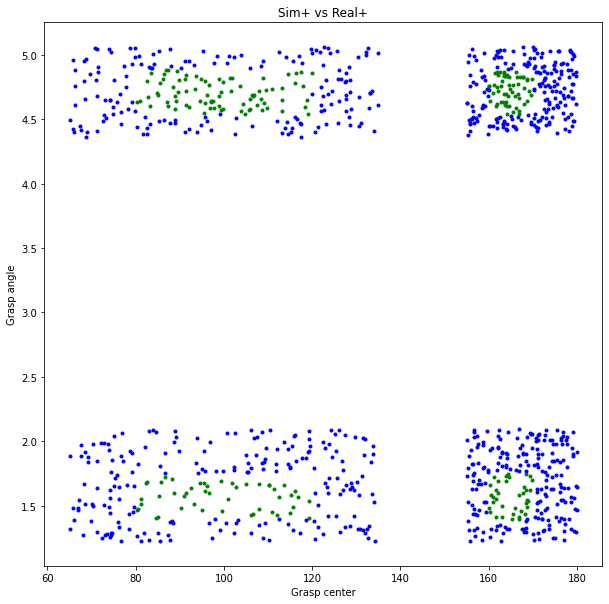

In [52]:
# np.sum(train_dataset.data[:,2])/train_dataset.data.shape[0]

# show the data
data = train_dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks



fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='g')
ax1.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.set_title('Sim+ vs Real+')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')

plt.show()

In [53]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel



# We will use the simplest form of GP model, exact inference
class ExactGPModel(ExactGP):
#     def __init__(self, train_x, train_y, likelihood, num_classes):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_t, train_y, likelihood)

# class DirichletGPModel(ExactGP):
#     def __init__(self, train_x, train_y, likelihood, num_classes):
#         super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
#         self.covar_module = ScaleKernel(
#             RBFKernel(batch_shape=torch.Size((num_classes,))),
#             batch_shape=torch.Size((num_classes,)),
#         )
        
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())


#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
# likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=False) 
# model = DirichletGPModel(x_t, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = likelihood(model(x_t))
#     print(output.loc[:10])
    
    # Calc loss and backprop gradients
#     loss = -mll(output, likelihood.transformed_targets).sum()
    loss = -mll(output, train_y).sum()
#     loss = -mll(output, ytrain_tensor)

    loss.backward()
    
#     train_accuracy = (torch.round(output.loc.clone()) == train_y).sum().item()
    
    if i % 10 == 0:
#         print(output.loc)

        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))        
#         print('Iter %d/%d - Loss: %.3f - Acc: %.3f' % (i + 1, training_iter, loss.item(), train_accuracy))
#         print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/100 - Loss: 1.330   lengthscale: 0.693   noise: 0.693
Iter 11/100 - Loss: 1.177   lengthscale: 0.327   noise: 0.324
Iter 21/100 - Loss: 0.873   lengthscale: 0.130   noise: 0.166
Iter 31/100 - Loss: 0.527   lengthscale: 0.045   noise: 0.065
Iter 41/100 - Loss: 0.499   lengthscale: 0.027   noise: 0.023
Iter 51/100 - Loss: 0.455   lengthscale: 0.026   noise: 0.011
Iter 61/100 - Loss: 0.467   lengthscale: 0.022   noise: 0.007
Iter 71/100 - Loss: 0.460   lengthscale: 0.022   noise: 0.005
Iter 81/100 - Loss: 0.472   lengthscale: 0.021   noise: 0.004
Iter 91/100 - Loss: 0.474   lengthscale: 0.021   noise: 0.003


In [62]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    print(observed_pred.loc)
    print(observed_pred.confidence_region())    

tensor([-0.9789, -0.9785, -0.9782, -0.9779, -0.9777, -0.9776, -0.9775, -0.9774,
        -0.9774, -0.9774, -0.9788, -0.9785, -0.9783, -0.9779, -0.9778, -0.9776,
        -0.9775, -0.9774, -0.9774, -0.9774, -0.9788, -0.9785, -0.9782, -0.9779,
        -0.9777, -0.9776, -0.9775, -0.9774, -0.9774, -0.9774, -0.9789, -0.9786,
        -0.9783, -0.9780, -0.9777, -0.9776, -0.9775, -0.9775, -0.9774, -0.9774,
        -0.9789, -0.9786, -0.9782, -0.9779, -0.9778, -0.9776, -0.9775, -0.9775,
        -0.9773, -0.9773, -0.9789, -0.9785, -0.9782, -0.9780, -0.9778, -0.9776,
        -0.9775, -0.9775, -0.9773, -0.9774, -0.9789, -0.9785, -0.9783, -0.9780,
        -0.9777, -0.9776, -0.9775, -0.9774, -0.9773, -0.9774, -0.9789, -0.9784,
        -0.9782, -0.9779, -0.9777, -0.9775, -0.9775, -0.9775, -0.9774, -0.9774,
        -0.9789, -0.9785, -0.9782, -0.9780, -0.9778, -0.9776, -0.9775, -0.9774,
        -0.9773, -0.9774, -0.9789, -0.9785, -0.9782, -0.9779, -0.9777, -0.9775,
        -0.9775, -0.9774, -0.9773, -0.97

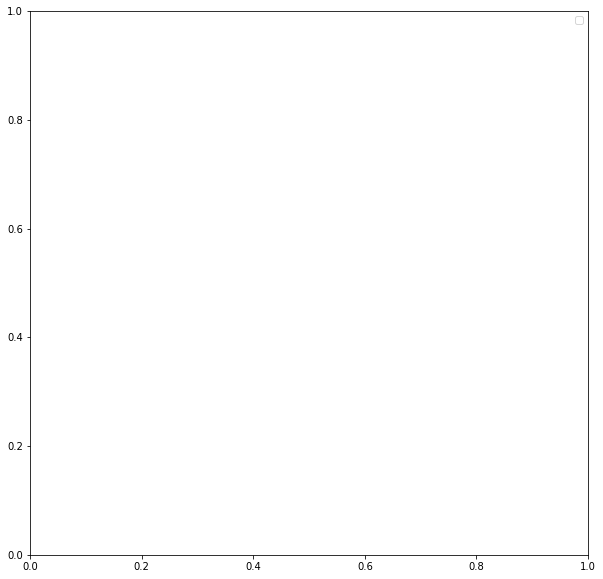

In [55]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
#     ax.plot(train_x[:,0].numpy(), train_x[:,1].numpy(), 'g.')
#     Plot predictive means as blue line
#     ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
#     ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [30]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/50 - Loss: 0.927   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.896   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.862   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.824   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.783   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.736   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.687   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.637   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.589   lengthscale: 0.372   noise: 0.370
Iter 10/50 - Loss: 0.545   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.505   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.468   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.433   lengthscale: 0.272   noise: 0.260
Iter 14/50 - Loss: 0.399   lengthscale: 0.257   noise: 0.237
Iter 15/50 - Loss: 0.366   lengthscale: 0.244   noise: 0.216
Iter 1

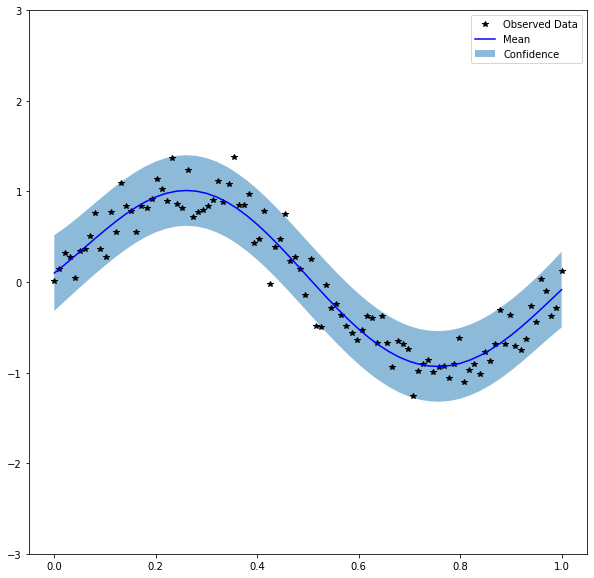

In [31]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [32]:
observed_pred.mean.numpy()

array([ 0.09812557,  0.18947819,  0.284452  ,  0.38125122,  0.4779306 ,
        0.5724105 ,  0.6625747 ,  0.74628603,  0.82148796,  0.88626313,
        0.93885905,  0.9778101 ,  1.0019084 ,  1.0103183 ,  1.0025498 ,
        0.9784902 ,  0.93840665,  0.8829393 ,  0.81306076,  0.7300594 ,
        0.63548285,  0.5310905 ,  0.41880497,  0.30066234,  0.17873928,
        0.05514041, -0.06809183, -0.18896541, -0.30561647, -0.41627946,
       -0.51935667, -0.61339694, -0.69710714, -0.7693649 , -0.82922226,
       -0.87591904, -0.90885025, -0.9276349 , -0.932062  , -0.9221379 ,
       -0.898084  , -0.8603583 , -0.809612  , -0.7467529 , -0.67289776,
       -0.58937067, -0.49768946, -0.39952847, -0.2966761 , -0.19102713,
       -0.08449242], dtype=float32)